# Differencing And Averaging Model

---

This notebook contains the code of differencing and averaging model to forecast the sales of the product.

---

## Loading the dataset

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [11]:
drive.mount("/content/gdrive")
dataset = pd.read_csv('gdrive/My Drive/PreprocessedOrders.csv', index_col='Period')
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6
Period,,,,,,
0,30,62,61,62,6,21
1,23,65,72,67,28,11
2,25,73,69,76,19,24
3,31,67,70,69,19,18
4,20,53,59,64,29,13


## Initializing the variables

In [12]:
rows = len(dataset)
dataset = dataset.to_numpy()
time = np.arange(rows, dtype="float32")

#Splitting the data for traing and validation
split_time = int(rows * 0.7)
time_train = time[:split_time]
dataset_train = dataset[:split_time]
time_validate = time[split_time:]
dataset_valid = dataset[split_time:]
window_size = 12
max_value = 100000

## Dataset Visualisation

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

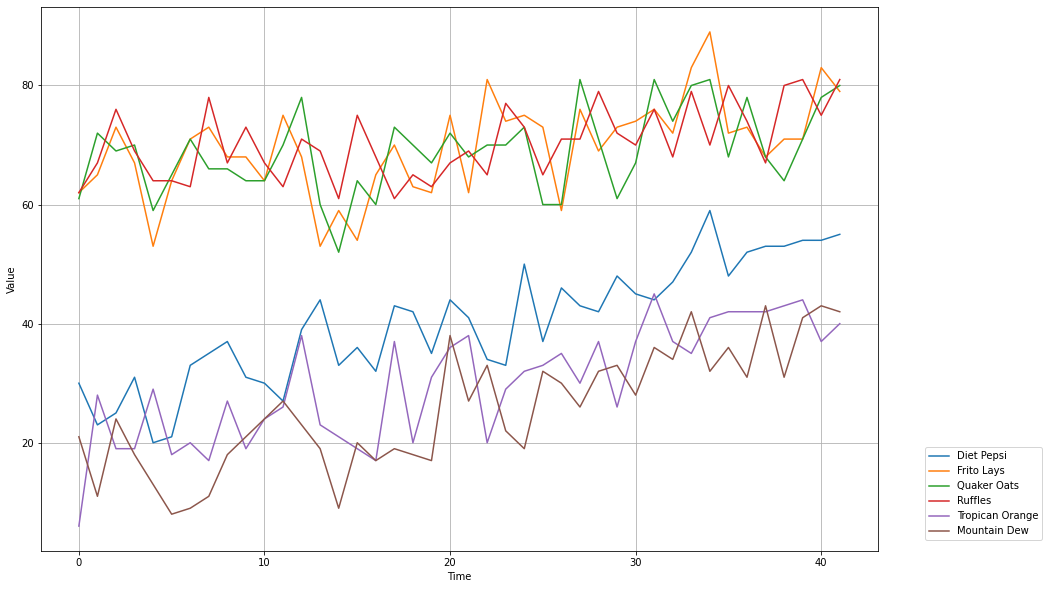

In [14]:
shortProductNames = ["Diet Pepsi", "Frito Lays", "Quaker Oats", "Ruffles", "Tropican Orange", "Mountain Dew"]
plt.figure(figsize=(15, 10))
plot_series(time_train, dataset_train)
plt.legend(shortProductNames, loc="upper left", bbox_to_anchor=(1.05, 0.0, 0.3, 0.2))
plt.show()

## Validating the model

In [15]:
"""Calculate the moving average of the series"""
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean(axis = 0))
  return np.array(forecast)

"""Calculate Symmetric Mean Absolute Percentage Error """
def SMAPE(actual, predicted):
  (rows, cols) = actual.shape
  updated_actual = actual
  updated_predicted = predicted

  model_error = 0

  for row in range(rows):
    for col in range(cols):
      if actual[row][col] == predicted[row][col] and actual[row][col] == 0:
          updated_actual[row][col] = 1
          updated_predicted[row][col] = 1
    
  for col in range(cols):
    model_error = model_error + round(np.mean(np.abs(updated_predicted[:, col] - updated_actual[:, col]) / ((np.abs(updated_predicted[:, col]) + np.abs(updated_actual[:, col]))/2))*100, 2)
  return model_error/cols

""" Validate the model on validation data """
def validate_model(seasonality=12, window_size=12):
    # taking difference by subtracting the last season values
    diff_dataset = (dataset[seasonality:] - dataset[:-seasonality])

    #moving average
    diff_moving_avg = moving_average_forecast(diff_dataset, window_size)[split_time - seasonality - window_size:]

    #adding moving average with the last season value
    last_season_semi_window_size = 3
    index_from = split_time - seasonality - (last_season_semi_window_size)
    index_to = -seasonality + (last_season_semi_window_size)
    predictions = moving_average_forecast(dataset[index_from: index_to], last_season_semi_window_size * 2) + diff_moving_avg
    predictions = np.clip(predictions, 0, max_value).astype(int)
    # graphs representation
    (_, products) = dataset.shape
    
    for product in range(products):
      plt.figure(figsize=(20, 4))
      
      plt.subplot(1, 3, 1)
      plot_series(time_validate, diff_dataset[split_time - seasonality:, product])
      plot_series(time_validate, diff_moving_avg[:, product])
      plt.title("Moving Average Graph for product %d" %(product + 1))
      plt.legend(["Actual Sales", "Moving Average"], loc ="upper left")

      plt.subplot(1, 3, 2)
      plot_series(time_validate, dataset_valid[:, product])
      plot_series(time_validate, predictions[:, product])
      plt.title("Validation Graph for product %d" %(product + 1))
      plt.legend(["Actual Sales", "Predicted Sales"], loc ="upper left")

      plt.subplot(1, 3, 3)
      plot_series(time_train, dataset_train[:, product])
      plot_series(time_validate, predictions[:, product])
      plt.title("Forecasting Graph for product %d" %(product + 1))
      plt.legend(["Actual Sales", "Predicted Sales"], loc ="upper left")
      plt.show()

    model_smape = SMAPE(dataset_valid, predictions)
    print("SMAPE error for the model is: %f"  %(model_smape))

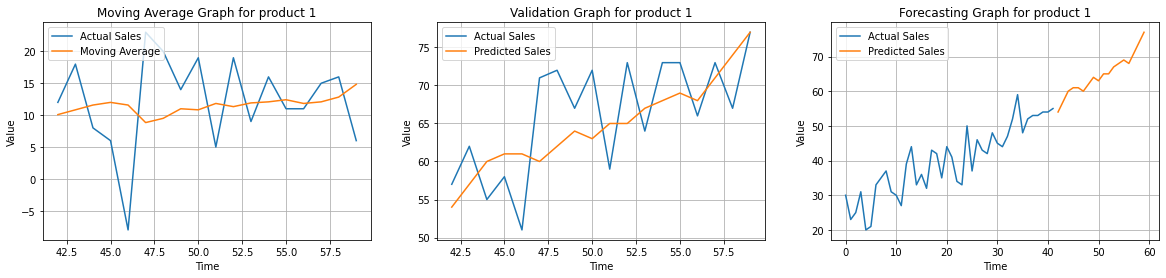

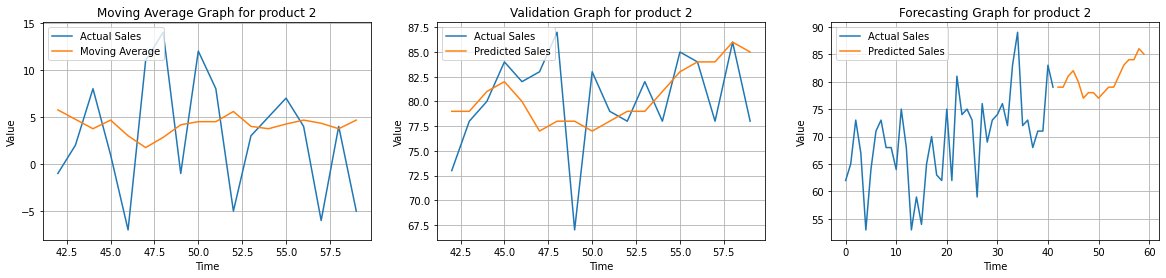

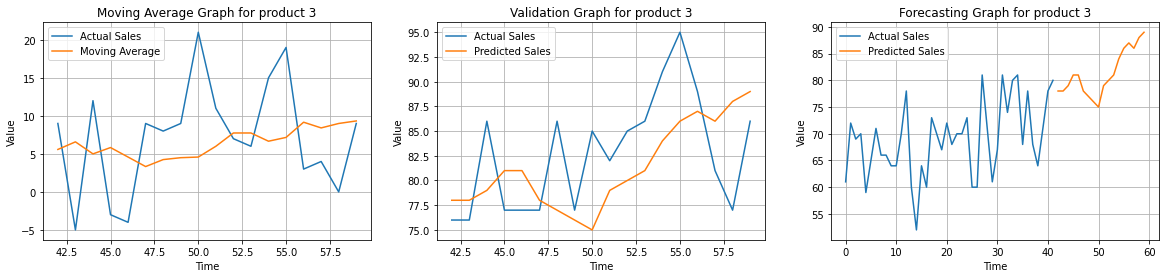

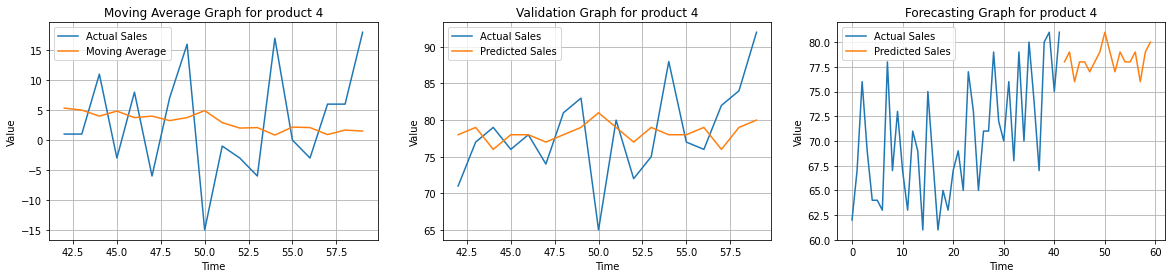

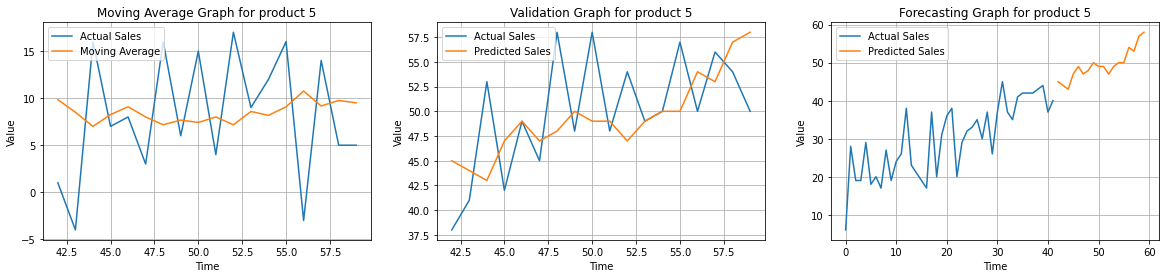

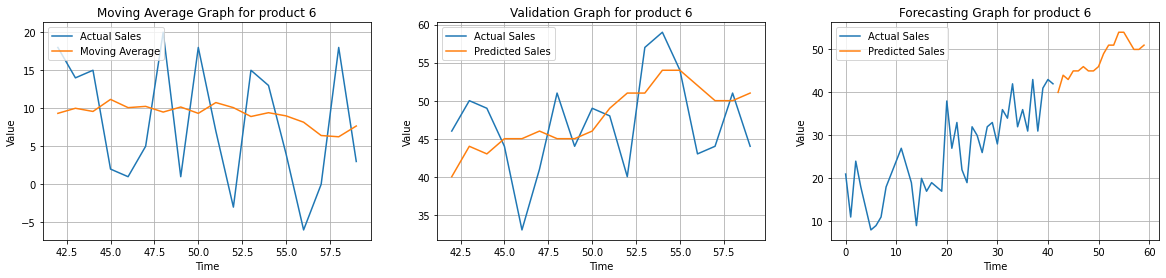

SMAPE error for the model is: 7.558333


In [16]:
validate_model()

## Predictions


In [17]:
def predict_sales(dataset, seasonality=12, window_size=12, duration=1):
    dataset_length = len(dataset)
    if(dataset_length <= seasonality):
        meanValue = dataset.mean(axis = 0)
        return np.full((duration, 1), meanValue, dtype=int)

    last_season_semi_window_size = 3
    index_from = dataset_length - duration - seasonality - (last_season_semi_window_size)
    index_to = -seasonality + (last_season_semi_window_size)
    diff_series = (dataset[seasonality:] - dataset[:-seasonality])
    diff_moving_avg = moving_average_forecast(diff_series, window_size)[dataset_length - seasonality - window_size-duration:]
    prediction = moving_average_forecast(dataset[index_from: index_to], 2*last_season_semi_window_size)  + diff_moving_avg
    prediction = np.clip(prediction, 0, max_value).astype(int)
    return prediction

In [18]:
# predicting the next period demand
output = predict_sales(dataset)
print(output)

[[77 85 89 80 58 51]]
